In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import brainflow
from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds

from brainflow.board_shim import BoardShim, BrainFlowInputParams, LogLevels, BoardIds
from brainflow.data_filter import DataFilter, FilterTypes, AggOperations, WindowFunctions, DetrendOperations

import mne
from mne.channels import read_layout
from scipy.fft import fft, fftfreq

board_id = BoardIds.CYTON_BOARD.value
#print(board_id)

def getData(time_sec):
    board.prepare_session()
    board.start_stream()
    #time.sleep(1) # one second to stabilize the board
    #print(board.get_board_data_count())
    time.sleep(time_sec) # data acquisition time
    #print(board.get_board_data_count())
    #data = board.get_board_data(250*time_sec) # take the last 2500 packets of data (about 10 seconds)
    data = board.get_board_data() # take the last 2500 packets of data (about 10 seconds)
    board.stop_stream()
    board.release_session()
    return data

def drawPSD(data_source):

    the_nfft = int(nfft*8.0)
    
    for i in eeg_channels:
        DataFilter.perform_highpass(data_source[i], sampling_rate, 2, 1, 0, 1) # removes DC offset
        DataFilter.perform_bandstop(data_source[i], sampling_rate, 50.0, 4.0, 2, FilterTypes.BUTTERWORTH.value, 0) # remove 50Hz line

        DataFilter.perform_bandpass(data_source[i], sampling_rate, 1.0, 40.0, 4, FilterTypes.BESSEL.value, 0)
        
    psd_7 = DataFilter.get_psd_welch(data_source[7], the_nfft, the_nfft//2, sampling_rate, 1)
    psd_8 = DataFilter.get_psd_welch(data_source[8], the_nfft, the_nfft//2, sampling_rate, 1)
    
    plt.plot(psd_7[1],psd_7[0], label='O1')
    plt.plot(psd_8[1],psd_8[0], label='O2')
    
def getPSD_fixed(data_source):

    the_nfft = int(nfft*8.0)
    
    for i in eeg_channels:
        DataFilter.perform_highpass(data_source[i], sampling_rate, 2, 1, 0, 1) # removes DC offset
        DataFilter.perform_bandstop(data_source[i], sampling_rate, 48.0, 52.0, 3, FilterTypes.BUTTERWORTH.value, 0)
        DataFilter.perform_bandpass(data_source[i], sampling_rate, 3.0, 40.0, 2, FilterTypes.BUTTERWORTH.value, 0)
        DataFilter.detrend(data_source[i], DetrendOperations.CONSTANT.value)

    psd_5 = DataFilter.get_psd_welch(data_source[5][250:], the_nfft, the_nfft//2, sampling_rate, 1)
    psd_6 = DataFilter.get_psd_welch(data_source[6][250:], the_nfft, the_nfft//2, sampling_rate, 1)
        
    psd_7 = DataFilter.get_psd_welch(data_source[7][250:], the_nfft, the_nfft//2, sampling_rate, 1)
    psd_8 = DataFilter.get_psd_welch(data_source[8][250:], the_nfft, the_nfft//2, sampling_rate, 1)
    
    return psd_5, psd_6, psd_7, psd_8
    
def drawPSD_fixed(psd_x, psd_label):
    
    plt.plot(psd_x[1],psd_x[0], label=psd_label)

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD')
    plt.legend(loc='upper right')
    

In [17]:
params = BrainFlowInputParams()
params.serial_port = "/dev/cu.usbserial-DM03H5VO"
board = BoardShim(BoardIds.CYTON_BOARD.value, params)

sampling_rate = BoardShim.get_sampling_rate(board_id)
nfft = DataFilter.get_nearest_power_of_two(sampling_rate)
eeg_channels = BoardShim.get_eeg_channels(board_id)
board.get_eeg_names(board_id)

['Fp1', 'Fp2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2']

In [ ]:
data = getData(10) # 10 seconds of data
dd7 = data[7] # take 7th electrode (O2)

In [343]:
#DataFilter.perform_highpass(dd7, sampling_rate, 2, 1, 0, 1) # removes DC offset
#DataFilter.perform_bandstop(dd7, sampling_rate, 48.0, 52.0, 3, FilterTypes.BUTTERWORTH.value, 0)
DataFilter.perform_bandpass(dd7, sampling_rate, 0.1, 30.0, 2, FilterTypes.BUTTERWORTH.value, 0)
DataFilter.detrend(dd7[250:], DetrendOperations.CONSTANT.value)

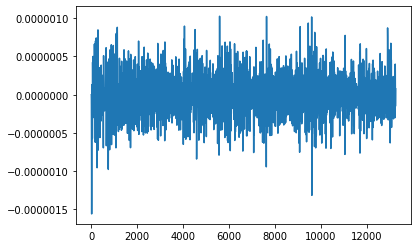

In [137]:
plt.plot(raw7)

Text(0.5, 1.0, 'EEG Screen Stimulation 20Hz, 30s')

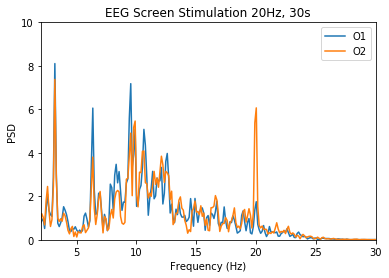

In [55]:
drawPSD_fixed(p7, 'O1')
drawPSD_fixed(p8, 'O2')

plt.xlim(2,30)
#plt.xlim(13,18)
plt.ylim(0,10)
plt.title('EEG Screen Stimulation 20Hz, 30s')

#plt.savefig('SSVEP_screen20Hz_2.png')

In [ ]:
def prepData(d1, ch): #notch and bandpass filters
    
    DataFilter.perform_highpass(d1[ch], sampling_rate, 2, 1, 0, 1) # removes DC offset
    DataFilter.perform_bandstop(d1[ch], sampling_rate, 48.0, 52.0, 3, FilterTypes.BUTTERWORTH.value, 0)
    DataFilter.perform_bandpass(d1[ch], sampling_rate, 3.0, 40.0, 2, FilterTypes.BUTTERWORTH.value, 0)
    DataFilter.detrend(d1[ch], DetrendOperations.CONSTANT.value)
    

def filterBank_12(d1, ch):
    the_nfft = int(nfft*2.0)
    
    psd_bg = DataFilter.get_psd_welch(d1[ch], the_nfft, the_nfft//2, sampling_rate, 1)
    band_power_bg = (DataFilter.get_band_power(psd_bg, 7.0, 27.0))/20.0
    
    d_copy = np.copy(d1)
    DataFilter.perform_bandpass(d_copy[ch], sampling_rate, 11.0, 13.0, 4, FilterTypes.CHEBYSHEV_TYPE_1.value, 1.0)
    psd = DataFilter.get_psd_welch(d_copy[ch], the_nfft, the_nfft//2, sampling_rate, 1)
    band_power = DataFilter.get_band_power(psd, 11.5, 12.5)
    
    print(band_power, band_power_bg)
    return band_power

def filterBank_15(d1, ch):
    the_nfft = int(nfft*2.0)
    
    psd_bg = DataFilter.get_psd_welch(d1[ch], the_nfft, the_nfft//2, sampling_rate, 1)
    band_power_bg = (DataFilter.get_band_power(psd_bg, 7.0, 27.0))/20.0
    
    d_copy = np.copy(d1)
    DataFilter.perform_bandpass(d_copy[ch], sampling_rate, 14.0, 16.0, 4, FilterTypes.CHEBYSHEV_TYPE_1.value, 1.0)
    psd = DataFilter.get_psd_welch(d_copy[ch], the_nfft, the_nfft//2, sampling_rate, 1)
    band_power = DataFilter.get_band_power(psd, 14.5, 15.5)
    
    print(band_power, band_power_bg)
    return band_power